# Exploratory data analysis
The goal of this project is to determine the best players to pick for an upcoming gameweek, based upon their previous performance and information about the upcoming fixtures. The primary response variable for this is the number of points a player scores in that game. This combines information about a players performance, including goals, assists, and many other variables. See here for a detailed description of the scoring methodology.

This is quite open-ended, meaning there are several diferent approaches I might take. Some options include:

- predicting players points directly using a linear regression (or similar) approach
- using Poisson regression, seeing how points are a discrete variable which might be modelled as a count
- use a classification framework, predicting who will score over a certain amount of points
This analysis should help to determine the best approach to use, as well as allowing us to explore the data. Before starting, I know that this will be a challenging task, as in sports (particularly football), past performance is not indicative of future results! As such, while a regression approach would be most useful in a general-sense, it might be that I have to settle for a classification approach.

In [1]:
import os

import keyring
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from sqlalchemy import create_engine
from sklearn.base import BaseEstimator, TransformerMixin

pd.options.display.max_columns = None
pd.options.display.max_rows = 100

DB_USER = 'harry'
DB_HOST = 'localhost'
DB_PORT = 5432
DB_NAME = 'fpl'
DB_KEYRING_NAME = 'db_fpl'
DB_PSWD = keyring.get_password(DB_KEYRING_NAME, DB_USER)


db_url = f'postgresql://{DB_USER}:{DB_PSWD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(db_url)

In [2]:
main_data = pd.read_sql("""SELECT * FROM players_full""", engine)
main_data['gameweek_id'] = main_data['gameweek_id'].astype(int)
main_data.sort_values(['player_id', 'gameweek_id'], inplace=True)

In [3]:
main_data.loc[main_data.player_id == '104'].sample(10).sort_values('gameweek_id')

player_id fixture_id fixture_id_long  gameweek_id team_id position_id  \
190       104          9         1059710            1       6           2   
220       104         78         1059779            8       6           2   
193       104        112         1059813           12       6           2   
195       104        132         1059833           14       6           2   
196       104        147         1059848           15       6           2   
197       104        154         1059855           16       6           2   
200       104        183         1059884           19       6           2   
203       104        202         1059903           21       6           2   
209       104        263         1059964           27       6           2   
213       104        353         1060054           36       6           2   

     total_points  fixture_home home_team_id away_team_id  home_team_score  \
190           0.0         False           12            6              4.0   
220           0.0         False           16            6              1.0   
193           0.0          True            6            7              2.0   
195           0.0          True            6           19              0.0   
196           0.0          True            6            2              2.0   
197           0.0         False            8            6              3.0   
200           1.0          True            6           16              0.0   
203           2.0         False            4            6              1.0   
209           0.0          True            6           17              2.0   
213           NaN          True            6           14              NaN   

     away_team_score  minutes  goals_scored  assists  clean_sheets  \
190              0.0        0           0.0      0.0           0.0   
220              4.0        0           0.0      0.0           0.0   
193              0.0        0           0.0      0.0           0.0   
195              1.0        0           0.0      0.0           0.0   
196              1.0        0           0.0      0.0           0.0   
197              1.0        0           0.0      0.0           0.0   
200              2.0       90           0.0      0.0           0.0   
203              1.0       90           0.0      0.0           0.0   
209              1.0       90           0.0      0.0           0.0   
213              NaN        0           NaN      NaN           NaN   

     goals_conceded  own_goals  penalties_saved  penalties_missed  \
190             0.0        0.0              0.0               0.0   
220             0.0        0.0              0.0               0.0   
193             0.0        0.0              0.0               0.0   
195             0.0        0.0              0.0               0.0   
196             0.0        0.0              0.0               0.0   
197             0.0        0.0              0.0               0.0   
200             2.0        0.0              0.0               0.0   
203             1.0        0.0              0.0               0.0   
209             1.0        1.0              0.0               0.0   
213             NaN        NaN              NaN               NaN   

     yellow_cards  red_cards  saves  bonus   bps  influence  creativity  \
190           0.0        0.0    0.0    0.0   0.0        0.0         0.0   
220           0.0        0.0    0.0    0.0   0.0        0.0         0.0   
193           0.0        0.0    0.0    0.0   0.0        0.0         0.0   
195           0.0        0.0    0.0    0.0   0.0        0.0         0.0   
196           0.0        0.0    0.0    0.0   0.0        0.0         0.0   
197           0.0        0.0    0.0    0.0   0.0        0.0         0.0   
200           0.0        0.0    0.0    0.0  17.0       11.4         1.9   
203           0.0        0.0    0.0    0.0  13.0       30.4         0.4   
209           0.0        0.0    0.0    0.0   6.0        1.6        14.1   
213           Na

In [4]:
with engine.connect() as con:
    most_recent_complete_gw = con.execute("""SELECT MAX(CAST(gameweek_id AS INTEGER))
    FROM gameweeks WHERE gameweek_finished""").first()[0]
    
print(f'Most recently completed gameweek: {most_recent_complete_gw}')

Most recently completed gameweek: 32


Note that due to the ongoing coronavirus situation (a tad unexpected), the gameweek (and several before) have not been played but have been set as complete in the source data. The most recent completed gameweek was gameweek 29.

In [5]:
most_recent_complete_gw = 29

Therefore, for now, all the data the model is to be trained and tested on will be up to gameweek 29. The rest can be discarded.

In [6]:
main_data = main_data.loc[main_data.gameweek_id <= most_recent_complete_gw]

In [7]:
main_data.shape

(16498, 35)

For the modelling approach, I am planning to split the data into training and testing sets whilst taking players into account, i.e. a player will only appear in one set.

Before this, I will do some basic exploratory analysis, without influencing feature selection. 

## Missing values

In [8]:
missing_vals = main_data.isna().mean()
missing_vals.loc[missing_vals > 0].sort_values(ascending=False)

Series([], dtype: float64)

The data coverage looks complete.

## Response variable
Before continuing with our main feature processing, now is a good time to look at the disrtibution of the target variable so we can decide the approach. I am in quite a flexible situation in that I am open to the type of model used - all I want to do is identify players likely to score highly. I could take three approaches:

- linear regression: modelling the number of points as a continuous variable
- Poisson regression: modelling the number of points as a discrete count variable. I envisage a couple of issues with this. Firstly, lots of players do not play or otherwise receive zero points, which is not supported by these kinds of models (this will to a smaller extent affect linear regression). We can get around this by using zero-inflated models. Secondly, players can receive negative points which is a bit more difficult to take care of.
- classification: we could turn this into a problem of classification where we look to predict points above a certain threshold. This might be an easier approach due to the number of zeros (and negatives) in the target variable. However, we would need to select a threshold and, from experience, most players which play recieve between 1 and 3 points, suggesting an unbalanced dataset.

In [9]:
min_pts = main_data['total_points'].min()
max_pts = main_data['total_points'].max()
print(f'Min points: {min_pts}\nMax points: {max_pts}')

Min points: -6.0
Max points: 24.0


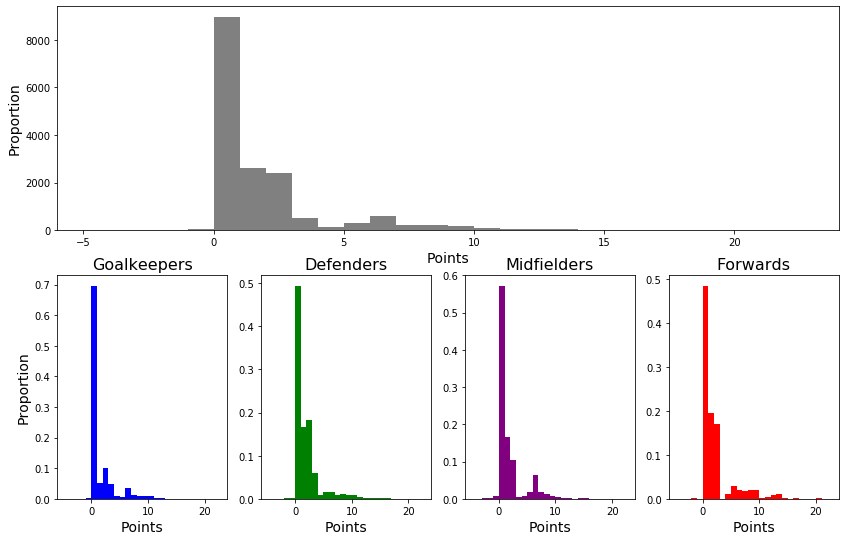

In [10]:
fig = plt.figure(figsize=(14,14))

# Get histogram bins from integers between the min and max points
#nbins = int(max_points-min_points + 1)
nbins = np.arange(min_pts, max_pts + 1)

# Subplots for all players, and then broken down by position
ax_all = plt.subplot2grid((3,4), (0,0), colspan=4)
ax_gkp = plt.subplot2grid((3,4), (1,0))
ax_def = plt.subplot2grid((3,4), (1,1))
ax_mid = plt.subplot2grid((3,4), (1,2))
ax_for = plt.subplot2grid((3,4), (1,3))

ax_all.hist(main_data['total_points'].dropna(), bins=nbins, color='grey')
ax_gkp.hist(main_data.loc[main_data['position_id']=='1',
                              'total_points'].dropna(), bins=nbins, color='blue', density=True)
ax_mid.hist(main_data.loc[main_data['position_id']=='2',
                              'total_points'].dropna(), bins=nbins, color='purple', density=True)
ax_def.hist(main_data.loc[main_data['position_id']=='3',
                              'total_points'].dropna(), bins=nbins, color='green', density=True)
ax_for.hist(main_data.loc[main_data['position_id']=='4',
                              'total_points'].dropna(), bins=nbins, color='red', density=True)

ax_gkp.set_title('Goalkeepers', fontsize=16)
ax_def.set_title('Defenders', fontsize=16)
ax_mid.set_title('Midfielders', fontsize=16)
ax_for.set_title('Forwards', fontsize=16)

for ax in [ax_all, ax_gkp, ax_def, ax_mid, ax_for]:
    ax.set_xlim(min_pts, max_pts)
    ax.set_xlabel('Points', fontsize=14)

ax_all.set_ylabel('Proportion', fontsize=14)
ax_gkp.set_ylabel('Proportion', fontsize=14)

plt.show()

We can see some bimodality in the target variable. Note, however, there are lots of players who do not play in each game.

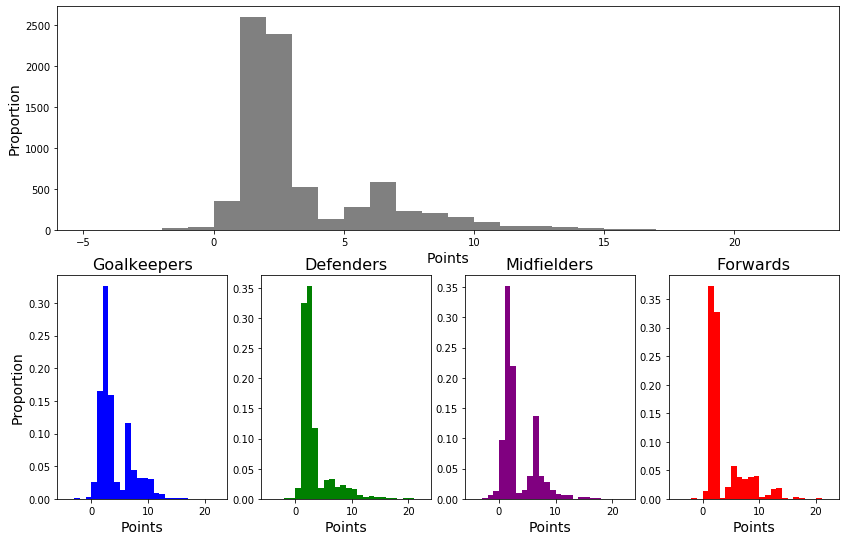

In [11]:
only_those_who_played = main_data.loc[main_data['minutes'] > 0]

fig = plt.figure(figsize=(14,14))

# Get histogram bins from integers between the min and max points
#nbins = int(max_points-min_points + 1)
nbins = np.arange(min_pts, max_pts + 1)

# Subplots for all players, and then broken down by position
ax_all = plt.subplot2grid((3,4), (0,0), colspan=4)
ax_gkp = plt.subplot2grid((3,4), (1,0))
ax_def = plt.subplot2grid((3,4), (1,1))
ax_mid = plt.subplot2grid((3,4), (1,2))
ax_for = plt.subplot2grid((3,4), (1,3))

ax_all.hist(only_those_who_played['total_points'].dropna(), bins=nbins, color='grey')
ax_gkp.hist(only_those_who_played.loc[only_those_who_played['position_id']=='1',
                              'total_points'].dropna(), bins=nbins, color='blue', density=True)
ax_mid.hist(only_those_who_played.loc[only_those_who_played['position_id']=='2',
                              'total_points'].dropna(), bins=nbins, color='purple', density=True)
ax_def.hist(only_those_who_played.loc[only_those_who_played['position_id']=='3',
                              'total_points'].dropna(), bins=nbins, color='green', density=True)
ax_for.hist(only_those_who_played.loc[only_those_who_played['position_id']=='4',
                              'total_points'].dropna(), bins=nbins, color='red', density=True)

ax_gkp.set_title('Goalkeepers', fontsize=16)
ax_def.set_title('Defenders', fontsize=16)
ax_mid.set_title('Midfielders', fontsize=16)
ax_for.set_title('Forwards', fontsize=16)

for ax in [ax_all, ax_gkp, ax_def, ax_mid, ax_for]:
    ax.set_xlim(min_pts, max_pts)
    ax.set_xlabel('Points', fontsize=14)

ax_all.set_ylabel('Proportion', fontsize=14)
ax_gkp.set_ylabel('Proportion', fontsize=14)

plt.show()

The bimodality is even clearer. Looking at this, it might be useful to perform binary classification on whether or not a player will get more than 4 points in a game. We do have the issue of unbalanced data, but this will be slightly less of an issue if we were to have a variable saying/predicting whether a player is to play.

One of the other options was to use Poisson regression to model the discrete number of points directly. However, we have several problems. From above, players can get negative points and there are many zeros. We also have clear bimodality. Finally, a key assumption of Poisson regression is that the mean and variance of the response are equal. This is not the case with our data:

In [12]:
ratio_mean_to_var = only_those_who_played['total_points'].mean()/only_those_who_played['total_points'].var()
print(f'Ratio of mean to variance of points: {ratio_mean_to_var}')

Ratio of mean to variance of points: 0.3378415136899831


We could look into negative binomial regression to address the problem of overdispersion. However, the multitude of violated assumptions will require lots of effort to overcome, so maybe this is something to focus on at a later date.

For now, I will focus on linear regression and classification approaches. For the latter, I will look to predict whether a player will score 5 or more points in a gameweek, as this seems to be a good split point and also what as a previous fantasy football player I would think is a useful score for a player to get.

# Deciding on approach
From the above analysis, it looks like it is worth, at least initially, performing binary classification to determine whether a player scores lots (5+) points. However, the above analysis has also shown a substantial amount of players do not play each game, meaning that there are a lot of zeros.
As a result, I am going to perform two separate classifications:
- Does a player play in the game?
- Assuming they play, will a player score 5 or more points?

I will train the second model only on players which do play, but predict for all future players. Alongside this, the inclusion of the separate playing a game prediction will allow filtering by players likely to play.

# Feature engineering
There are some features I expect to be able to derive from the data and which are likely to have some sort of impact on predictions.
For efficiency, I will be able to perform some on the data before splitting into training and testing sets. These might be combinations of column values for each individual row, or previous game data for players (remembering splitting will take players into account).

Other features to create may need to be aggregated from the whole data, so I will create classes and invoke those in the modelling pipelines.

### From other tables
There are several other tables in the database which contain information about the teams players play for and the games themselves.

#### Teams

In [13]:
team_data = pd.read_sql("""SELECT * FROM teams""", engine)
team_data.sort_values(['team_id'], inplace=True)
team_data

team_id team_id_long  team_name_long team_name  team_strength  \
0        1            3         Arsenal       ARS              4   
1       10           14       Liverpool       LIV              5   
2       11           43        Man City       MCI              5   
3       12            1         Man Utd       MUN              4   
4       13            4       Newcastle       NEW              3   
5       14           45         Norwich       NOR              2   
6       15           49   Sheffield Utd       SHU              3   
7       16           20     Southampton       SOU              3   
8       17            6           Spurs       TOT              4   
9       18           57         Watford       WAT              3   
10      19           21        West Ham       WHU              2   
11       2            7     Aston Villa       AVL              2   
12      20           39          Wolves       WOL              4   
13       3           91     Bournemouth       BOU              2   
14       4           36        Brighton       BHA              2   
15       5           90         Burnley       BUR              3   
16       6            8         Chelsea       CHE              4   
17       7           31  Crystal Palace       CRY              3   
18       8           11         Everton       EVE              3   
19       9           13       Leicester       LEI              3   

    team_strength_overall_home  team_strength_overall_away  \
0                         1180                        1240   
1                         1340                        1350   
2                         1330                        1340   
3                         1220                        1300   
4                         1090                        1100   
5                          980                        1020   
6                         1180                        1200   
7                         1150                        1040   
8                         1180                        1240   
9                         1030                        1140   
10                        1040                        1030   
11                        1020                        1050   
12                        1230                        1190   
13                        1020                        1020   
14                        1050                        1010   
15                        1110                        1180   
16                        1220                        1230   
17                        1130                        1120   
18                        1100                        1240   
19                        1210                        1160   

    team_strength_attack_home  team_strength_attack_away  \
0                        1170                       1170   
1                        1310                       1320   
2                        1260                       1270   
3                        1260                       1330   
4                        1030                       1040   
5                        1030                       1040   
6                        1170                       1180   
7                        1080                       1050   
8                        1100                       1130   
9                        1120                       1120   
10                       1000                       1030   
11                        970                        980   
12                       1180                       1230   
13                        990                       1030   
14                       1100                       1100   
15                       1130                       1070   
16                       1240                       1240   
17                       1080                       1180   
18                       1100                       1210   
19                       1150                       1080   

    team_s

There are several columns of interest relating to team strength - an attacking player playing for a team with a great attack may tend to score more points per game. Subsetting the columns to keep for later merge:

In [14]:
team_cols = ['team_id'] + [col for col in team_data.columns if col.startswith('team_strength')]

#### Team results and fixtures
Similarly, by looking at previous results, we may be able to find teams which are in form, and likely for their players to continue scoring well.

In [15]:
results = pd.read_sql("""SELECT * FROM team_results""", engine)
results.head(10)

team_id fixture_id fixture_id_long gameweek_id opponent_team_id  \
0       1         10         1059711           1               13   
1       1         11         1059712           2                5   
2       1         24         1059725           3               10   
3       1         31         1059732           4               17   
4       1         49         1059750           5               18   
5       1         51         1059752           6                2   
6       1         67         1059768           7               12   
7       1         71         1059772           8                3   
8       1         88         1059789           9               15   
9       1         91         1059792          10                7   

   goals_conceded  goals_scored fixture_kickoff_datetime  played  \
0             0.0           1.0      2019-08-11 14:00:00    True   
1             1.0           2.0      2019-08-17 12:30:00    True   
2             3.0           1.0      2019-08-24 17:30:00    True   
3             2.0           2.0      2019-09-01 16:30:00    True   
4             2.0           2.0      2019-09-15 16:30:00    True   
5             2.0           3.0      2019-09-22 16:30:00    True   
6             1.0           1.0      2019-09-30 20:00:00    True   
7             0.0           1.0      2019-10-06 14:00:00    True   
8             1.0           0.0      2019-10-21 20:00:00    True   
9             2.0           2.0      2019-10-27 16:30:00    True   

   fixture_home  win  draw  loss  points  goal_difference  
0         False  1.0   0.0   0.0       3              1.0  
1          True  1.0   0.0   0.0       3              1.0  
2         False  0.0   0.0   1.0       0             -2.0  
3          True  0.0   1.0   0.0       1              0.0  
4         False  0.0   1.0   0.0       1              0.0  
5          True  1.0   0.0   0.0       3              1.0  
6         False  0.0   1.0   0.0       1              0.0  
7          True  1.0   0.0   0.0       3              1.0  
8         False  0.0   0.0   1.0       0             -1.0  
9          True  0.0   1.0   0.0       1              0.0

Things of interest here include the opponent team, goals each team has scored (plus the result), date/time of the match, and whether it was played home or away.

In [16]:
results_cols = ['fixture_id', 'team_id' ,'opponent_team_id', 'goals_scored',
               'goals_conceded', 'win', 'loss', 'draw']

The results table is just a version of the fixtures table, except being a bit more processed. Two additional useful columns in the fixtures table are home_team_fixture_difficulty and away_team_fixture_difficulty, which can be later merged on to the results data.

In [17]:
fixtures = pd.read_sql("""SELECT * FROM fixtures""", engine)
fixtures.head(10)

fixture_id fixture_id_long gameweek_id fixture_kickoff_datetime  \
0          1         1059702           1      2019-08-09 20:00:00   
1         10         1059711           1      2019-08-11 14:00:00   
2        100         1059801          10      2019-10-26 15:00:00   
3        101         1059803          11      2019-11-02 15:00:00   
4        102         1059804          11      2019-11-02 15:00:00   
5        103         1059802          11      2019-11-02 12:30:00   
6        104         1059805          11      2019-11-02 15:00:00   
7        105         1059806          11      2019-11-03 14:00:00   
8        106         1059807          11      2019-11-03 16:30:00   
9        107         1059808          11      2019-11-02 15:00:00   

  fixture_started  fixture_finished  fixture_finished_provisional  \
0            True              True                          True   
1            True              True                          True   
2            True              True                          True   
3            True              True                          True   
4            True              True                          True   
5            True              True                          True   
6            True              True                          True   
7            True              True                          True   
8            True              True                          True   
9            True              True                          True   

   fixture_minutes home_team_id away_team_id  home_team_score  \
0               90           10           14              4.0   
1               90           13            1              0.0   
2               90           19           15              1.0   
3               90            1           20              1.0   
4               90            2           10              1.0   
5               90            3           12              1.0   
6               90            4           14              2.0   
7               90            7            9              0.0   
8               90            8           17              1.0   
9               90           11           16              2.0   

   away_team_score  home_team_fixture_difficulty  away_team_fixture_difficulty  
0              1.0                             2                             5  
1              1.0                             3                             2  
2              1.0                             3                             2  
3              1.0                             4                             4  
4              2.0                             4                             2  
5              0.0                             4                             2  
6              0.0                             2                             2  
7              2.0                             3                             3  
8              1.0                             3                             4  
9              1.0                             3                             4

In [18]:
fixtures_cols = ['fixture_id', 'home_team_id', 'away_team_id', 'home_team_fixture_difficulty', 'away_team_fixture_difficulty']

In [19]:
def show_table(table, eng, rows=10):
    print(pd.read_sql(f'SELECT * FROM {table}', eng).head(rows))

# ==> Make function to preprocess data

In [20]:
fixtures_home = fixtures[fixtures_cols].drop(columns=['away_team_id'])
fixtures_home.rename(columns={'home_team_id': 'team_id',
                             'home_team_fixture_difficulty': 'team_fixture_difficulty',
                             'away_team_fixture_difficulty': 'opponent_team_fixture_difficulty'}, inplace=True)

fixtures_away = fixtures[fixtures_cols].drop(columns=['home_team_id'])
fixtures_away.rename(columns={'away_team_id': 'team_id',
                             'away_team_fixture_difficulty': 'team_fixture_difficulty',
                             'home_team_fixture_difficulty': 'opponent_team_fixture_difficulty'}, inplace=True)

In [21]:
combined_data = main_data.copy(deep=True)
print(f'Shape pre-merge: {combined_data.shape}')
combined_data = combined_data.merge(team_data[team_cols], how='left', on='team_id')

rename_cols = {'goals_scored': 'team_goals_scored',
               'goals_conceded': 'team_goals_conceded'}
combined_data = combined_data.merge(results[results_cols].rename(columns=rename_cols), how='left', on=['fixture_id', 'team_id'])

rename_cols = {k: f'opponent_{k}' for k in team_cols}
combined_data = combined_data.merge(team_data[team_cols].rename(columns=rename_cols), how='left', on='opponent_team_id')


combined_data = combined_data.merge(fixtures_home, how='left', on=['team_id', 'fixture_id'])
combined_data = combined_data.merge(fixtures_away, how='left', on=['team_id', 'fixture_id'])

combined_data['team_fixture_difficulty'] = combined_data['team_fixture_difficulty_x']\
                                                    .combine_first(combined_data['team_fixture_difficulty_y'])
combined_data['opponent_team_fixture_difficulty'] = combined_data['opponent_team_fixture_difficulty_x']\
                                                    .combine_first(combined_data['opponent_team_fixture_difficulty_y'])
combined_data.drop(columns=['team_fixture_difficulty_x',
                           'team_fixture_difficulty_y',
                           'opponent_team_fixture_difficulty_x',
                           'opponent_team_fixture_difficulty_y'], inplace=True)
print(f'Shape post-merge: {combined_data.shape}')

Shape pre-merge: (16498, 35)
Shape post-merge: (16498, 57)


In [22]:
combined_data.isna().sum().sort_values(ascending=False).head()

opponent_team_fixture_difficulty    0
threat                              0
influence                           0
bps                                 0
bonus                               0
dtype: int64

The merges worked successfully and no missing values have been introduced.

### Previous games
The dataframe has quite a few features already, but most of them refer to the game the number of points is for. Before a game we obviously won't know the values for these features!

A simple solution is to, for each player, look to past games rather than dropping the values.

In [23]:
combined_data.columns

Index(['player_id', 'fixture_id', 'fixture_id_long', 'gameweek_id', 'team_id',
       'position_id', 'total_points', 'fixture_home', 'home_team_id',
       'away_team_id', 'home_team_score', 'away_team_score', 'minutes',
       'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
       'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards',
       'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity',
       'threat', 'ict_index', 'value', 'transfers_balance', 'selected',
       'transfers_in', 'transfers_out', 'kickoff_datetime', 'team_strength',
       'team_strength_overall_home', 'team_strength_overall_away',
       'team_strength_attack_home', 'team_strength_attack_away',
       'team_strength_defence_home', 'team_strength_defence_away',
       'opponent_team_id', 'team_goals_scored', 'team_goals_conceded', 'win',
       'loss', 'draw', 'opponent_team_strength',
       'opponent_team_strength_overall_home',
       'opponent_team_strength_overall_away

In [24]:
combined_data.head()

player_id fixture_id fixture_id_long  gameweek_id team_id position_id  \
0         1         10         1059711            1       1           2   
1         1         11         1059712            2       1           2   
2         1         24         1059725            3       1           2   
3         1         31         1059732            4       1           2   
4         1         49         1059750            5       1           2   

   total_points  fixture_home home_team_id away_team_id  home_team_score  \
0           0.0         False           13            1              0.0   
1           0.0          True            1            5              2.0   
2           0.0         False           10            1              3.0   
3           0.0          True            1           17              2.0   
4           0.0         False           18            1              2.0   

   away_team_score  minutes  goals_scored  assists  clean_sheets  \
0              1.0        0           0.0      0.0           0.0   
1              1.0        0           0.0      0.0           0.0   
2              1.0        0           0.0      0.0           0.0   
3              2.0        0           0.0      0.0           0.0   
4              2.0        0           0.0      0.0           0.0   

   goals_conceded  own_goals  penalties_saved  penalties_missed  yellow_cards  \
0             0.0        0.0              0.0               0.0           0.0   
1             0.0        0.0              0.0               0.0           0.0   
2             0.0        0.0              0.0               0.0           0.0   
3             0.0        0.0              0.0               0.0           0.0   
4             0.0        0.0              0.0               0.0           0.0   

   red_cards  saves  bonus  bps  influence  creativity  threat  ict_index  \
0        0.0    0.0    0.0  0.0        0.0         0.0     0.0        0.0   
1        0.0    0.0    0.0  0.0        0.0         0.0     0.0        0.0   
2        0.0    0.0    0.0  0.0        0.0         0.0     0.0        0.0   
3        0.0    0.0    0.0  0.0        0.0         0.0     0.0        0.0   
4        0.0    0.0    0.0  0.0        0.0         0.0     0.0        0.0   

   value  transfers_balance  selected  transfers_in  transfers_out  \
0   55.0                0.0   33117.0           0.0            0.0   
1   55.0            -5280.0   36709.0        2868.0         8148.0   
2   54.0            -6882.0   30975.0         534.0         7416.0   
3   54.0            -3872.0   28096.0         346.0         4218.0   
4   53.0            -2073.0   26902.0         581.0         2654.0   

     kickoff_datetime  team_strength  team_strength_overall_home  \
0 2019-08-11 14:00:00              4                        1180   
1 2019-08-17 12:30:00              4                        1180   
2 2019-08-24 17:30:00              4                        1180   
3 2019-09-01 16:30:00              4                        1180   
4 2019-09-15 16:30:00              4                        1180   

   team_strength_overall_away  team_strength_attack_home  \
0                        1240                       1170   
1                        1240                       1170   
2                        1240                       1170   
3                        1240                       1170   
4                        1240                       1170   

   team_strength_attack_away  team_strength_defence_home  \
0                       1170                        1150   
1                       1170                        1150   
2                       1170                        1150   
3                       1170                        1150   
4                       1170                        1150   

   team_strength_defence_away opponent_team_id  team_goals_scored  \
0                        1200               13                1.0   
1                        1200                

In [25]:
cols_not_known_in_advance = ['home_team_score',
                            'away_team_score',
                            'minutes',
                            'goals_scored',
                            'assists',
                            'clean_sheets',
                            'goals_conceded',
                            'own_goals',
                            'penalties_saved',
                            'penalties_missed',
                            'yellow_cards',
                            'red_cards',
                            'saves',
                            'bonus',
                            'bps',
                            'influence',
                            'creativity',
                            'threat',
                            'ict_index',
                            'team_goals_scored',
                            'win',
                            'loss',
                            'draw']

The above columns are not known until the total_points is known, so I will 'lag' them in the data - for each player there'll be additional features in place of these, corresponding to the values in the previous game.
It would be good to have multiple games' data for each player, but this'll mean reducing the number of rows in the data (as the first few games obviously do not have much previous game data).

In [26]:
combined_data = combined_data.copy(deep=True)
combined_data.sort_values(['player_id', 'kickoff_datetime'], inplace=True)
gb_obj = combined_data.groupby('player_id')
combined_data[[f'previous_{col}' for col in cols_not_known_in_advance]] = gb_obj[cols_not_known_in_advance].shift(1)
combined_data.drop(columns=cols_not_known_in_advance, inplace=True)

In [27]:
combined_data.head()

player_id fixture_id fixture_id_long  gameweek_id team_id position_id  \
0         1         10         1059711            1       1           2   
1         1         11         1059712            2       1           2   
2         1         24         1059725            3       1           2   
3         1         31         1059732            4       1           2   
4         1         49         1059750            5       1           2   

   total_points  fixture_home home_team_id away_team_id  value  \
0           0.0         False           13            1   55.0   
1           0.0          True            1            5   55.0   
2           0.0         False           10            1   54.0   
3           0.0          True            1           17   54.0   
4           0.0         False           18            1   53.0   

   transfers_balance  selected  transfers_in  transfers_out  \
0                0.0   33117.0           0.0            0.0   
1            -5280.0   36709.0        2868.0         8148.0   
2            -6882.0   30975.0         534.0         7416.0   
3            -3872.0   28096.0         346.0         4218.0   
4            -2073.0   26902.0         581.0         2654.0   

     kickoff_datetime  team_strength  team_strength_overall_home  \
0 2019-08-11 14:00:00              4                        1180   
1 2019-08-17 12:30:00              4                        1180   
2 2019-08-24 17:30:00              4                        1180   
3 2019-09-01 16:30:00              4                        1180   
4 2019-09-15 16:30:00              4                        1180   

   team_strength_overall_away  team_strength_attack_home  \
0                        1240                       1170   
1                        1240                       1170   
2                        1240                       1170   
3                        1240                       1170   
4                        1240                       1170   

   team_strength_attack_away  team_strength_defence_home  \
0                       1170                        1150   
1                       1170                        1150   
2                       1170                        1150   
3                       1170                        1150   
4                       1170                        1150   

   team_strength_defence_away opponent_team_id  team_goals_conceded  \
0                        1200               13                  0.0   
1                        1200                5                  1.0   
2                        1200               10                  3.0   
3                        1200               17                  2.0   
4                        1200               18                  2.0   

   opponent_team_strength  opponent_team_strength_overall_home  \
0                       3                                 1090   
1                       3                                 1110   
2                       5                                 1340   
3                       4                                 1180   
4                       3                                 1030   

   opponent_team_strength_overall_away  opponent_team_strength_attack_home  \
0                                 1100                                1030   
1                                 1180                                1130   
2                                 1350                                1310   
3                                 1240                                1100   
4                                 1140                                1120   

   opponent_team_strength_attack_away  opponent_team_strength_defence_home  \
0                                1040                                  980   
1                                1070                                  970   
2                                1320                                 1310   
3                                1130  

### Derived features
There are several more features we can derive from the data.
- **Form:** A measure of a player's form is difficult to construct as it would require several gameweeks worth of data. As mentioned above, this would cut down the data size too much for my current liking. It should, however, be the case that previous gameweek features should act as a proxy for this, albeit only base on a single game.
- **Popularity:** During the data preparation there was one additional feature which came to mind which I have not yet added: a more appropriate measure of the number of FPL player teams containing each player. This exists as the variable 'selected', however each gameweek there are different numbers of teams entered into the competition which means that our assumption that each gameweek is considered 'equal' breaks down. While this assumption is imperfect anyway (double gameweeks, player transfers, teams playing in other competitions etc.), over the course of the season the player base increases dramatically.
- **Further team-level statistics:** Along with things like goals previously scored, conceded by a team, there are other features I could derive per team such as numbers of unique scorers etc. However, I will leave this to a later date.

For now I will just focus on the popularity variable. However, as this is based across all players per gameweek, it would be wrong (with the planned cross validation where I will allow each player to only have rows in either the train or validation data) to calculate this in advance. It will need to be calculated in the cross validation loop. With Scikit-learn pipelines, this is simple to do by creating a custom-transformer subclassing BaseEstimator and TransformerMixin.

This will be useful for other variables such as transfers which also depend on the playerbase size.

In [28]:
full_data = combined_data.copy(deep=True)

by_group = 'gameweek_id'
variables = ['selected', 'transfers_in', 'transfers_out']
quantiles = [round(i/10, 2) for i in range(10)]


quantile_data = full_data.groupby(by_group)[variables].quantile(quantiles)
quantile_data = quantile_data.reset_index().rename(columns={'level_1': 'quantile'})
low_cols = [f'{b}_lower' for b in variables]
quantile_data.rename(columns=dict(zip(variables, low_cols)), inplace=True)


quantile_data[[f'{b}_upper' for b in variables]] = quantile_data.groupby(by_group)[low_cols].shift(-1).fillna(9999)

In [30]:
full_data2 = full_data.merge(quantile_data, how='left', on=by_group)
for var in variables:
    full_data2[f'quantile_{var}'] = np.nan
    mask = (full_data2[var] >= full_data2[f'{var}_lower']) & (full_data2[var] < full_data2[f'{var}_upper'])
    full_data2.loc[mask, f'quantile_{var}'] = full_data2.loc[mask, f'quantile']
    
full_cols = [col for col in full_data2.columns if not col.startswith('quantile_') and not col.endswith(('_upper', '_lower'))]
quantile_cols = [col for col in full_data2.columns if col.startswith('quantile_')]
full_data2 = full_data2.groupby(['player_id', 'gameweek_id', 'fixture_id'])[quantile_cols].max().reset_index()
full_data2.head(10)

player_id  gameweek_id fixture_id  quantile_selected  quantile_transfers_in  \
0         1            1         10                0.5                    0.9   
1         1            2         11                0.5                    0.5   
2         1            3         24                0.4                    0.3   
3         1            4         31                0.4                    0.2   
4         1            5         49                0.4                    0.3   
5         1            6         51                0.4                    0.3   
6         1            7         67                0.4                    0.3   
7         1            8         71                0.4                    0.4   
8         1            9         88                0.4                    0.4   
9         1           10         91                0.4                    0.3   

   quantile_transfers_out  
0                     0.9  
1                     0.6  
2                     0.5  
3                     0.4  
4                     0.4  
5                     0.4  
6                     0.3  
7                     0.3  
8                     0.3  
9                     0.3

This is far too slow and will make cross validation too frustrating to run, so for now I will simply calculate the percentage selected. Essentially, this is just 

In [31]:
full_data.head()

player_id fixture_id fixture_id_long  gameweek_id team_id position_id  \
0         1         10         1059711            1       1           2   
1         1         11         1059712            2       1           2   
2         1         24         1059725            3       1           2   
3         1         31         1059732            4       1           2   
4         1         49         1059750            5       1           2   

   total_points  fixture_home home_team_id away_team_id  value  \
0           0.0         False           13            1   55.0   
1           0.0          True            1            5   55.0   
2           0.0         False           10            1   54.0   
3           0.0          True            1           17   54.0   
4           0.0         False           18            1   53.0   

   transfers_balance  selected  transfers_in  transfers_out  \
0                0.0   33117.0           0.0            0.0   
1            -5280.0   36709.0        2868.0         8148.0   
2            -6882.0   30975.0         534.0         7416.0   
3            -3872.0   28096.0         346.0         4218.0   
4            -2073.0   26902.0         581.0         2654.0   

     kickoff_datetime  team_strength  team_strength_overall_home  \
0 2019-08-11 14:00:00              4                        1180   
1 2019-08-17 12:30:00              4                        1180   
2 2019-08-24 17:30:00              4                        1180   
3 2019-09-01 16:30:00              4                        1180   
4 2019-09-15 16:30:00              4                        1180   

   team_strength_overall_away  team_strength_attack_home  \
0                        1240                       1170   
1                        1240                       1170   
2                        1240                       1170   
3                        1240                       1170   
4                        1240                       1170   

   team_strength_attack_away  team_strength_defence_home  \
0                       1170                        1150   
1                       1170                        1150   
2                       1170                        1150   
3                       1170                        1150   
4                       1170                        1150   

   team_strength_defence_away opponent_team_id  team_goals_conceded  \
0                        1200               13                  0.0   
1                        1200                5                  1.0   
2                        1200               10                  3.0   
3                        1200               17                  2.0   
4                        1200               18                  2.0   

   opponent_team_strength  opponent_team_strength_overall_home  \
0                       3                                 1090   
1                       3                                 1110   
2                       5                                 1340   
3                       4                                 1180   
4                       3                                 1030   

   opponent_team_strength_overall_away  opponent_team_strength_attack_home  \
0                                 1100                                1030   
1                                 1180                                1130   
2                                 1350                                1310   
3                                 1240                                1100   
4                                 1140                                1120   

   opponent_team_strength_attack_away  opponent_team_strength_defence_home  \
0                                1040                                  980   
1                                1070                                  970   
2                                1320                                 1310   
3                                1130  

In [29]:
gw_sel = (full_data.groupby('gameweek_id')['selected'].sum()/15).to_frame(name='selected_total')
temp = full_data.copy(deep=True)
temp = temp[['player_id', 'gameweek_id', 'selected']].merge(gw_sel, on='gameweek_id', how='left')
temp['selected_pct'] = temp['selected']/temp['selected_total']

In [30]:
print(type((full_data.groupby('gameweek_id')['selected'].sum()/15)))
print(type((full_data.groupby('gameweek_id')[['selected', 'transfers_in']].sum()/15)))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


In [60]:
z = full_data.groupby('gameweek_id')[['selected', 'transfers_in']].sum()/15
z.rename(columns={k: f'{k}_perc' for k in z.columns})

selected_perc  transfers_in_perc
gameweek_id                                  
1             5.443649e+06           0.000000
2             6.126451e+06      626097.466667
3             6.347990e+06      838075.333333
4             6.529600e+06      823431.000000
5             6.675942e+06      770554.600000
6             6.747588e+06      496644.000000
7             6.818508e+06      584497.600000
8             6.866870e+06      455534.466667
9             6.922849e+06      512887.066667
10            6.950129e+06      325365.133333
11            6.994694e+06      461484.000000
12            7.026666e+06      398457.666667
13            7.073013e+06      495543.866667
14            7.098229e+06      439434.600000
15            7.115945e+06      279316.733333
16            7.141351e+06      334806.933333
17            7.178640e+06      398740.000000
18            6.261257e+06      355177.333333
19            7.232930e+06      336383.466667
20            7.252738e+06      277612.533333
21            7.280066e+06      378786.466667
22            7.316827e+06      466567.333333
23            7.343805e+06      452946.733333
24            8.629298e+06      549704.600000
25            7.388372e+06      528762.600000
26            7.405874e+06      345499.933333
27            7.426160e+06      355978.066667
28            5.850931e+06      320282.800000
29            7.451437e+06      431150.466667

Note that if it is a new gameweek (as will be the case for new predictions, we will need to calculate percentages from only that current gameweeks data for the new gameweeks, so the transform step in the pipeline step will need to reuse the percentage calculation.

The constant, 15, is used as this is the size of a user's squad (i.e. they select 15 players per gameweek so we need to divide the total number of selected players by 15 in the calculation).

In [62]:
testdata = combined_data.copy(deep=True)
by_group='gameweek_id'
variables=['selected', 'transfers_in', 'transfers_out']
constant=15

suffix_final = '_total'
small = testdata.loc[:, ['player_id', 'gameweek_id'] + variables]

gb_percs = small.loc[small.gameweek_id <= 27].groupby(by_group)[variables].sum()/constant
if isinstance(gb_percs, pd.DataFrame):
    gb_percs.columns = [f'{k}{"_tmp"}' for k in variables]
else:
    gb_percs.to_frame(name=f'{variables[0]}')


all_groups = small[by_group]
add_gws = set(all_groups) - set(gb_percs.index)

new_gb_percs = small.loc[small.gameweek_id.isin(add_gws)].groupby(by_group)[variables].sum()/constant
if isinstance(gb_percs, pd.DataFrame):
    new_gb_percs.columns = [f'{k}{"_tmp"}' for k in variables]
else:
    new_gb_percs.to_frame(name=f'{variables[0]}')
    
updated_gb_percs = pd.concat((gb_percs, new_gb_percs))

small2= small.merge(gb_percs, how='left', left_on=by_group, right_index=True)
for c in variables:
    small2[f'{c}{suffix_final}'] = small2[c] / small2[f'{c}{"_tmp"}']

0.5836324878534773

In [47]:
class PercentageCalc(BaseEstimator, TransformerMixin):
    
    def __init__(self,
                 by_group='gameweek_id',
                 variables=['selected', 'transfers_in', 'transfers_out'],
                 final_suffix='_perc',
                 constant=15):
        self._by_group = by_group
        self._variables = variables
        self._constant = constant
        self._final_suffix = final_suffix
        self._temp_columns = [f'{k}{"_tmp"}' for k in self._variables]
        self.totals = None
        
    def _needed_new_bygroup(self, X):
        all_groups = X[self._by_group]
        return set(all_groups) - set(self.totals.index)
    
    def _calc_totals(self, X):
        percs = X.groupby(self._by_group)[self._variables].sum()/self._constant
        if isinstance(percs, pd.DataFrame):
            percs.columns = self._temp_columns
            return percs
        else:
            return percs.to_frame(name=f'{variables[0]}')
    
    def _apply_totals(self, X, totals):
        return X.merge(totals, how='left', left_on=self._by_group, right_index=True)
    
    def _calc_final(self, X):
        for c in self._variables:
            X[f'{c}{self._final_suffix}'] = X[c] / X[f'{c}{"_tmp"}']
            X[f'{c}{self._final_suffix}'].fillna(0, inplace=True)
        return X
    
    def _drop_original_cols(self, X):
        return X.drop(columns=self._variables + self._temp_columns)        
        
    def fit(self, X, y=None):
        self.totals = self._calc_totals(X)
        
    def transform(self, X):
        new_calcs = self._needed_new_bygroup(X)
        if new_calcs is None:
            X = self._apply_totals(X, self.totals)
        else:
            new_totals = self._calc_totals(X.loc[X[self._by_group].isin(new_calcs)])
            final_totals = pd.concat((self.totals, new_totals))
            X = self._apply_totals(X, final_totals)
        X = self._calc_final(X)
        return self._drop_original_cols(X)

In [48]:
testdata = combined_data.loc[:,
                         ['player_id', 'gameweek_id'] +
                         ['selected', 'transfers_in', 'transfers_out', 'fixture_id']].copy(deep=True)

suffix_final = '_total'
data_1 = testdata.loc[testdata.gameweek_id <= 28]
data_2 = testdata.loc[testdata.gameweek_id >28]

cfv = PercentageCalc(by_group='gameweek_id',
                     variables=['selected', 'transfers_in', 'transfers_out'],
                     constant=15)
cfv.fit(data_1)
output = cfv.transform(testdata)
output.head(10)

player_id  gameweek_id fixture_id  selected_perc  transfers_in_perc  \
0         1            1         10       0.006084           0.000000   
1         1            2         11       0.005992           0.004581   
2         1            3         24       0.004879           0.000637   
3         1            4         31       0.004303           0.000420   
4         1            5         49       0.004030           0.000754   
5         1            6         51       0.003902           0.000751   
6         1            7         67       0.003761           0.000614   
7         1            8         71       0.003681           0.000863   
8         1            9         88       0.003637           0.000846   
9         1           10         91       0.003602           0.000612   

   transfers_out_perc  
0            0.000000  
1            0.013014  
2            0.008849  
3            0.005122  
4            0.003444  
5            0.002847  
6            0.002609  
7            0.002380  
8            0.001761  
9            0.001610

In [60]:
res = small.groupby(by_group).quantile(bounds).reset_index()
#res.rename(columns={'level_1': 'quantile'}, inplace=True)
low_cols = [f'{c}_lower' for c in variables]
res.columns = [by_group, 'quantile'] + low_cols
res.loc[res.gameweek_id==10].sample(10).sort_values('quantile')

gameweek_id  quantile  selected_lower  transfers_in_lower  \
90           10      0.00            0.00                0.00   
91           10      0.01          265.25                5.00   
92           10      0.02          634.10                7.00   
93           10      0.03          899.25                8.00   
94           10      0.04         1066.80               10.00   
95           10      0.05         1391.50               12.75   
96           10      0.06         1701.80               14.30   
97           10      0.07         1942.80               16.85   
98           10      0.08         2187.00               18.00   
99           10      0.09         2478.65               21.00   

    transfers_out_lower  
90                 0.00  
91                 8.00  
92                16.30  
93                29.25  
94                39.40  
95                45.50  
96                49.00  
97                59.55  
98                66.40  
99                73.95

In [61]:
res.head()

gameweek_id  quantile  selected_lower  transfers_in_lower  \
0            1      0.00            0.00                 0.0   
1            1      0.01          213.25                 0.0   
2            1      0.02          507.50                 0.0   
3            1      0.03         1082.25                 0.0   
4            1      0.04         1528.00                 0.0   

   transfers_out_lower  
0                  0.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  0.0

In [56]:
small2 = small.copy()
res2 = res.copy()
res2[[f'{b}_upper' for b in variables]] = res2.groupby(by_group)[low_cols].shift(-1).fillna(9999)
res2.loc[res.gameweek_id == 10].head(20).sort_values('quantile')
small2 = small2.merge(res2, on=by_group, how='left')
small2.head()

gameweek_id  selected  transfers_in  transfers_out  quantile  \
0            1   33117.0           0.0            0.0      0.00   
1            1   33117.0           0.0            0.0      0.01   
2            1   33117.0           0.0            0.0      0.02   
3            1   33117.0           0.0            0.0      0.03   
4            1   33117.0           0.0            0.0      0.04   

   selected_lower  transfers_in_lower  transfers_out_lower  selected_upper  \
0            0.00                 0.0                  0.0          213.25   
1          213.25                 0.0                  0.0          507.50   
2          507.50                 0.0                  0.0         1082.25   
3         1082.25                 0.0                  0.0         1528.00   
4         1528.00                 0.0                  0.0         1860.00   

   transfers_in_upper  transfers_out_upper  
0                 0.0                  0.0  
1                 0.0                  0.0  
2                 0.0                  0.0  
3                 0.0                  0.0  
4                 0.0                  0.0

In [57]:
x='selected'
correct_c = (small2[x] >= small2[f'{x}_lower']) & (small2[x] < small2[f'{x}_upper'])
correct_c.sum()

4823

In [47]:
small2 = small.head()
res2 = res.copy()
res2[[f'{b}_upper' for b in variables]] = res2.groupby(by_group)[low_cols].shift(-1).fillna(9999)
res2.loc[res.gameweek_id==10].head(20).sort_values('quantile')

small2 = small2.merge(res2, on=by_group, how='left')
for x in variables:
    correct_c = (small2[x] >= small2[f'{x}_lower'])
                  & (small2[x] < small2[f'{x}_upper'])
    small2.loc[correct_c, f'{x}_quantile'] = small2.loc[correct_c, quantile]
    small2

small2.head()

gameweek_id  selected  transfers_in  transfers_out  quantile  \
0            1   33117.0           0.0            0.0      0.00   
1            1   33117.0           0.0            0.0      0.01   
2            1   33117.0           0.0            0.0      0.02   
3            1   33117.0           0.0            0.0      0.03   
4            1   33117.0           0.0            0.0      0.04   

   selected_lower  transfers_in_lower  transfers_out_lower  selected_upper  \
0            0.00                 0.0                  0.0          213.25   
1          213.25                 0.0                  0.0          507.50   
2          507.50                 0.0                  0.0         1082.25   
3         1082.25                 0.0                  0.0         1528.00   
4         1528.00                 0.0                  0.0         1860.00   

   transfers_in_upper  transfers_out_upper  
0                 0.0                  0.0  
1                 0.0                  0.0  
2                 0.0                  0.0  
3                 0.0                  0.0  
4                 0.0                  0.0

In [ ]:
class GroupedPercentiles(BaseEstimator, TransformerMixin):
    
    def __init__(self,
                 by_group='gameweek_id',
                 variables=['selected', 'transfers_in', 'transfers_out'],
                 bounds=[0.1*round(i/10, 2) for i in range(10)])
        self._by_group = by_group
        self._variables = variables
        self._bounds = bounds
        self._quantile_locs = None
        
    def fit(self, X, y=None):
        res = X.groupby(self._by_group).quantile(self._bounds).reset_index()
        res.rename(columns={'level_1': 'quantile'}, inplace=True)
        
        pass
    
    def _get_quantiles(self):
        pass
    
    def transform(self, X):
        # Check group is available, otherwise refit using additional group(s)
        pass
        

In [117]:
small[[f'percentile_{c}' for c in variables]] =\
        small.groupby(by_group).transform(lambda q: pd.qcut(q, 5, labels=False))

ValueError: transform must return a scalar value for each group

In [104]:
small[[f'percentile_{c}' for c in variables]] = small.groupby(by_group).rank(pct=True)
small

gameweek_id   selected  transfers_in  transfers_out  \
0                1    33117.0           0.0            0.0   
1                2    36709.0        2868.0         8148.0   
2                3    30975.0         534.0         7416.0   
3                4    28096.0         346.0         4218.0   
4                5    26902.0         581.0         2654.0   
5                6    26330.0         373.0         1414.0   
6                7    25642.0         359.0         1525.0   
7                8    25277.0         393.0         1084.0   
8                9    25175.0         434.0          903.0   
9               10    25037.0         199.0          524.0   
10              11    24909.0         426.0          837.0   
11              12    24731.0         228.0          620.0   
12              13    24575.0         306.0          743.0   
13              14    24142.0         107.0          629.0   
14              15    24214.0         294.0          308.0   
15              16    24078.0         147.0          352.0   
16              17    23907.0         120.0          437.0   
17              18    23900.0         190.0          395.0   
18              19    23785.0         106.0          287.0   
19              20    23718.0          65.0          210.0   
20              21    23807.0         212.0          248.0   
21              22    23892.0         259.0          367.0   
22              23    23827.0         156.0          346.0   
23              24    23904.0         160.0          179.0   
24              25    23916.0         502.0          611.0   
25              26    24927.0        1204.0          356.0   
26              27    27539.0        3113.0          851.0   
27              29    27137.0         750.0         1058.0   
28               1     6135.0           0.0            0.0   
29               2     5767.0         174.0         1011.0   
30               3     5091.0         116.0          875.0   
31               4     4739.0         146.0          571.0   
32               5     5245.0         801.0          556.0   
33               6     6817.0        1470.0          417.0   
34               7     9171.0        2486.0          687.0   
35               8    10597.0        1770.0          733.0   
36               9    10962.0         975.0          907.0   
37              10    10834.0         381.0          669.0   
38              11    10579.0         468.0          985.0   
39              12    10002.0         238.0          921.0   
40              13    10160.0         740.0          822.0   
41              14     9501.0         150.0          825.0   
42              15     9400.0         151.0          329.0   
43              16     9119.0         132.0          484.0   
44              17     8427.0         118.0          865.0   
45              18     7833.0          15.0          586.0   
46              19     7678.0          24.0          252.0   
47              20     7497.0          10.0          196.0   
48              21     7247.0          31.0          289.0   
49              22     7575.0         396.0          254.0   
50              23     7687.0         216.0          230.0   
51              24     7652.0         110.0          219.0   
52              25     8042.0         552.0          342.0   
53              26     7995.0         161.0          256.0   
54              27     7953.0         136.0          284.0   
55              29     7836.0          98.0          176.0   
56               1     5770.0           0.0            0.0   
57               2     6144.0         195.0          830.0   
58               3     5677.0          89.0          852.0   
59               4     5391.0          95.0          547.0   
60               5     5253.0         176.0          498.0   
61               6     5978.0         722.0          241.0   
62               7     5277.0          96.0          767.0   
63               8     5940.0         7

In [105]:
small2 = small.copy(deep=True)
small2

In [ ]:
class GroupedPercentiles(BaseEstimator, TransformerMixin):
    
    def __init__(self,
                 by_group='gameweek_id',
                 variables=['selected', 'transfers_in', 'transfers_out'],
                 bounds=[0.1*round(i/10, 2) for i in range(100)])
        self._by_group = by_group
        self._variables = variables
        self._bounds = bounds
        
    def fit(self, X, y=None):
        pass
    
    def transform(self, X):
        pass
        

# Feature exploration

## Categoricals

## Numerics